## Expected Free Energy for Acrobot

Wouter Kouw, last update: 21-01-2023

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-acrobot`


In [2]:
using Optim
using ForwardDiff
using Zygote
using Printf
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)

include("util/coordinates.jl")
include("util/util.jl")

UT (generic function with 1 method)

## Equations of motion

References: 
- https://www.youtube.com/watch?v=QE1_H2vtHLU (EoM for the Double Compound Pendulum, "Good Vibrations with Freeball").
- https://underactuated.mit.edu/acrobot.html#section1

![](figures/acrobot.svg)

Using Lagrangian mechanics, we obtain the following equations of motion:

$$\begin{align} 
J_a \ddot{\theta}_1 + J_x \cos(\theta_1 - \theta_2)\ddot{\theta}_2 + J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 + \mu_1 \sin \theta_1 - K_t (\theta_2 - \theta_1) &= 0 \\
J_b \ddot{\theta}_2 + J_x \cos(\theta_1 - \theta_2)\ddot{\theta}_1 - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 + \mu_2 \sin \theta_2 - K_t (\theta_2 - \theta_1) &= 0
\end{align}$$

where we've used the shorthand notation:

$$\begin{align}
J_a = \frac{1}{3}m_1 l_1^2 + m_2 l_1^2 \, , \quad
J_b = \frac{1}{3}m_2 l_2^2 \, , \quad
J_x = \frac{1}{2}m_2 l_1 l_2 \, , \quad
\mu_1 = (\frac{1}{2}m_1 + m_2)Gl_2 \, , \quad
\mu_2 = \frac{1}{2}m_2 G l_2 \, .
\end{align}$$

We'd like to isolate the second-order derivates on one side:

$$\begin{align} 
J_a \ddot{\theta}_1 + J_x \cos(\theta_1 - \theta_2)\ddot{\theta}_2 &= - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
J_x \cos(\theta_1 - \theta_2)\ddot{\theta}_1 + J_b \ddot{\theta}_2 &= J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1)
\end{align}$$

We can formulate the left-hand side as a matrix-vector product:

$$\begin{align} 
\underbrace{\begin{bmatrix} J_a & J_x \cos(\theta_1 - \theta_2) \\ J_x \cos(\theta_1 - \theta_2) & J_b \end{bmatrix}}_{M(\theta_1, \theta_2)} \begin{bmatrix} \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = \begin{bmatrix} - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
 J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1) \end{bmatrix}
\end{align}$$

and then move the mass matrix to the right-hand side:

$$\begin{align} 
\begin{bmatrix} \ddot{\theta}_1 \\ \ddot{\theta}_2 \end{bmatrix} = M(\theta_1, \theta_2)^{-1} \begin{bmatrix} - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
 J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1) \end{bmatrix}
\end{align}$$

The inverse mass matrix can be derived manually:

$$\begin{align}
M(\theta_1,\theta_2)^{-1} = \frac{1}{J_a J_b - J_x^2 \cos(\theta_1 - \theta_2)^2} \begin{bmatrix} J_b & -J_x \cos(\theta_1 - \theta_2) \\ -J_x \cos(\theta_1 - \theta_2) & J_a \end{bmatrix}
\end{align}$$


Now, we can use variable substitution, 

$$\begin{align}
z = \begin{bmatrix} \theta_1 & \theta_2 & \dot{\theta}_1 & \dot{\theta}_2 \end{bmatrix}^{\top}
\end{align} \, ,$$

to transform this into a first-order system:

$$\begin{align} 
\dot{z} = \begin{bmatrix} z_3 \\ z_4 \\ M(z_1,z_2)^{-1} \begin{bmatrix} - J_x \sin(\theta_1 - \theta_2)\dot{\theta}_2^2 - \mu_1 \sin \theta_1 + K_t (\theta_2 - \theta_1) \\
 J_x \sin(\theta_1 - \theta_2)\dot{\theta}_1^2 - \mu_2 \sin \theta_2 + K_t (\theta_2 - \theta_1) \end{bmatrix} \end{bmatrix}
\end{align}$$

In [87]:
# Define time scales
tspan = (0.,10.)
dt = 0.01
time = tspan[1]:dt:tspan[end]
len_time = length(time)

1001

In [113]:
# System parameters
m1 = 1   # kg
m2 = 1   # kg
l1 = 1   # m
l2 = 1   # m
c1 = 1   # friction coefficient (dimensionless)
c2 = 1   # friction coefficient (dimensionless)
kt = 0.0   # Torsional spring
const G = 9.81 # N or kg*m / s^2

# Shorthand notation
Ja = 1/3*m1*l1^2 + m2*l1^2
Jb = 1/3*m2*l2^2
Jx = 1/2*m2*l1*l2
μ1 = (1/2*m1 + m2)*G*l1
μ2 = 1/2*m2*G*l2

4.905

In [114]:
function dzdt(z,u)
    
    # Inverse mass (inertia matrix)
    Mi = 1/(Ja*Jb - (Jx*cos(z[1] - z[2]))^2)*[Jb -(Jx*cos(z[1] - z[2]));-(Jx*cos(z[1] - z[2])) Ja]
    
    # Equations of motion
    ddθ1 = -Jx*sin(z[1] - z[2])*z[4]^2 - μ1*sin(z[1]) + kt*sin(z[2] - z[1]) - c1*z[3] + u[1]
    ddθ2 =  Jx*sin(z[1] - z[2])*z[3]^2 - μ2*sin(z[2]) + kt*sin(z[2] - z[1]) - c2*z[4] + u[2]
    ddθ = Mi*[ddθ1, ddθ2]
    
    return [z[3]; z[4]; ddθ[1]; ddθ[2]]
end

function f(z,u)
     return z + dt*dzdt(z,u)
end

f (generic function with 1 method)

In [115]:
Fz(z,u) = Zygote.jacobian(x -> f(x, u), z)[1]

Fz (generic function with 1 method)

In [169]:
# Measurement noise
R = 1e-6*diagm(ones(4));

# Nonlinear observation
C = [1. 0. 0. 0.;
     0. 1. 0. 0.]
g(z) = [-l1*cos(C[1,:]'*z), l1*sin(C[1,:]'*z), -l2*cos(C[2,:]'*z), l2*sin(C[2,:]'*z)]

g (generic function with 1 method)

In [170]:
function update(z_kmin1, u_k)
   "Update environment" 
    
    # State transition
    z_k = f(z_kmin1, u_k)
    
    # Emit noisy observation
    y_k = rand(MvNormal(g(z_k), R))
    
    return y_k, z_k
end;

In [171]:
# Control for checking dynamics simulation
cutpoint = 100
# u = [zeros(len_time) [3*ones(cutpoint); zeros(len_time-cutpoint)]]'
u = zeros(2,len_time)

2×1001 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [198]:
# Initial state
z_0 = [-π+rand(), 0.0, 0.0, 0.0]

# Preallocate
z_ = zeros(4,len_time)
y_ = zeros(4,len_time)

# Start recursion
z_kmin1 = z_0
for k in 1:len_time
    
    # Update system
    y_[:,k], z_[:,k] = update(z_kmin1, u[:,k])
    
    # Update recursion
    z_kmin1 = z_[:,k]
    
end

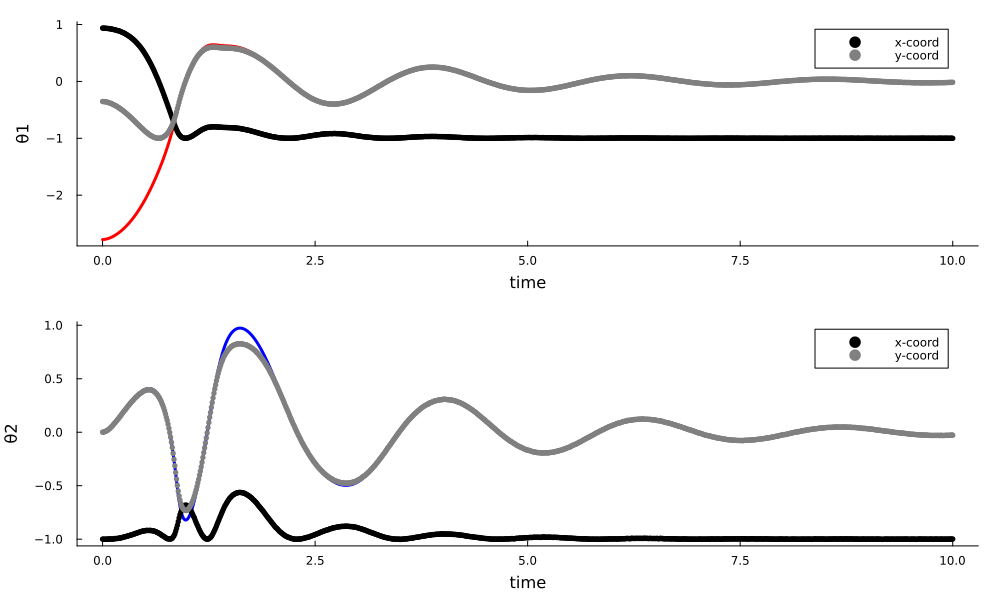

In [199]:
p101 = plot(time, z_[1,:], color="red", xlabel="time", ylabel="θ1")
scatter!(time, y_[1,:], color="black", markerstrokewidth=0, label="x-coord")
scatter!(time, y_[2,:], color="gray", markerstrokewidth=0, label="y-coord")
p102 = plot(time, z_[2,:], color="blue", xlabel="time", ylabel="θ2")
scatter!(time, y_[3,:], color="black", markerstrokewidth=0, label="x-coord")
scatter!(time, y_[4,:], color="gray", markerstrokewidth=0, label="y-coord")
plot(p101,p102, layout=(2,1), size=(1000,600))

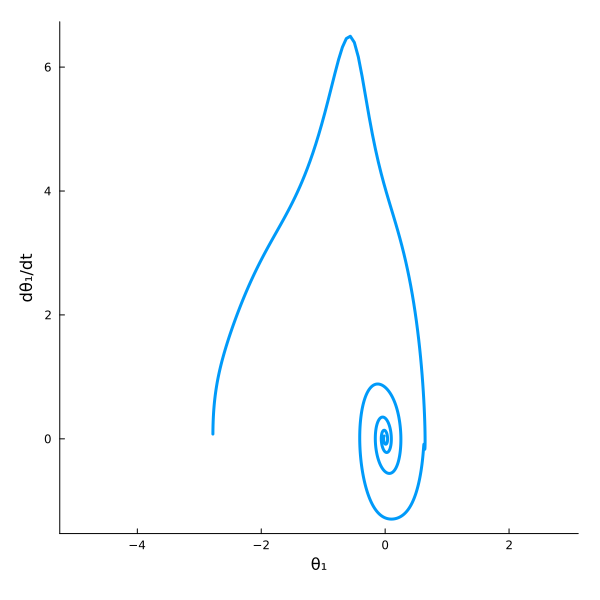

In [200]:
plot(z_[1,:], z_[3,:], xlabel="θ₁", ylabel="dθ₁/dt", size=(600,600), aspect_ratio=:equal)

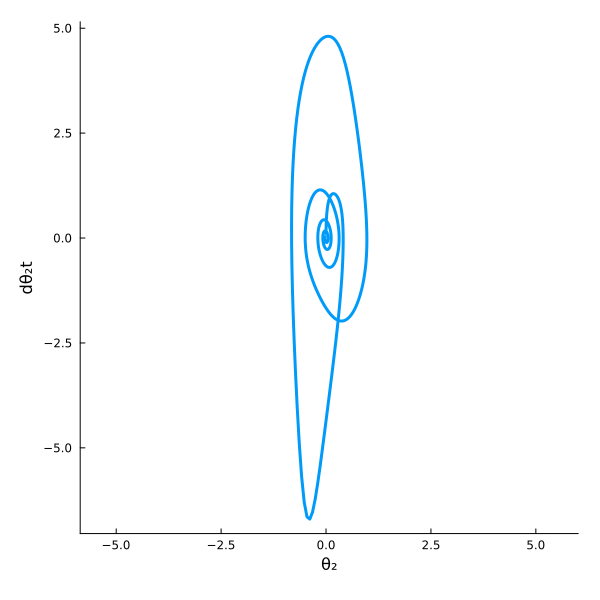

In [201]:
plot(z_[2,:], z_[4,:], xlabel="θ₂", ylabel="dθ₂t", size=(600,600), aspect_ratio=:equal)

[ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-acrobot/figures/acrobot-freesim.gif


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-acrobot/figures/acrobot-freesim.gif")
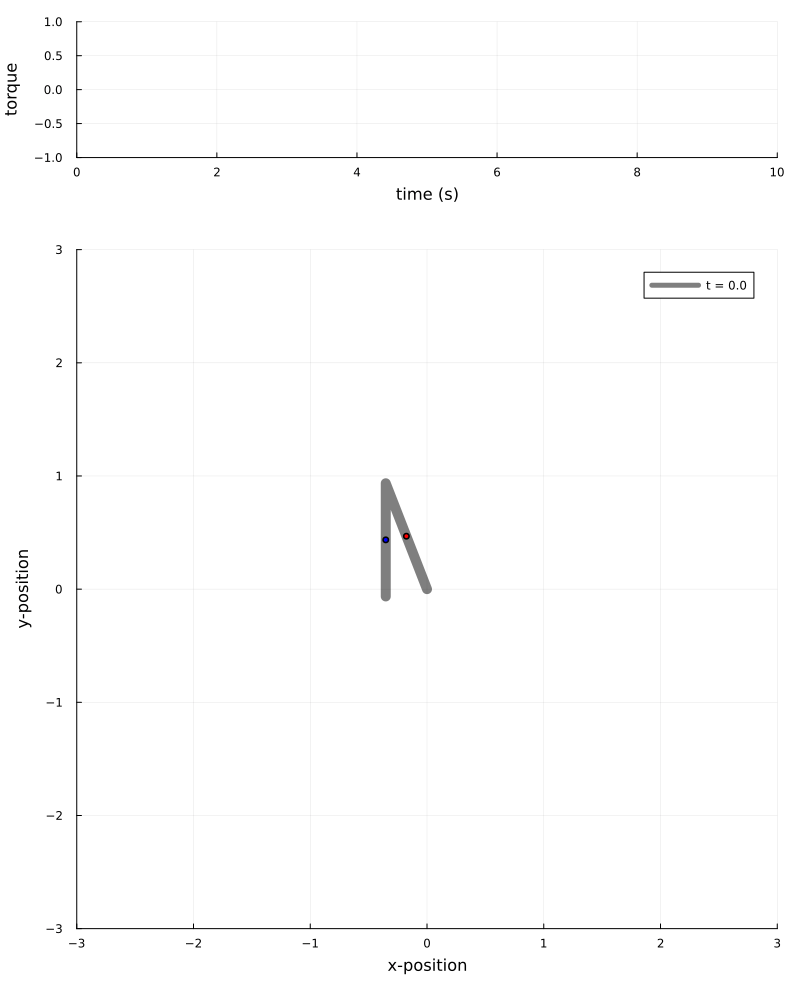

In [202]:
anim = @animate for (i,t) in enumerate(time)
   
    # Cartesian positions of centers of mass
    com1, com2 = polar2cart_com(z_[:,i], l1=l1, l2=l2)
    
    # Cartesian positions of rod endpoints
    rod1, rod2 = polar2cart_rod(z_[:,i], l1=l1, l2=l2)
    
    # Concatenate
    pen_k = [0 0; rod1[1] rod1[2]; rod2[1] rod2[2]]
    
    # Plot line
    p1 = plot(pen_k[:,1], pen_k[:,2], linewidth=10, alpha=0.5, label=@sprintf("t = %.1f", t), xlims=[-3,3], ylims=[-3,3], grid=true, color="black")
    
    # Point masses
    scatter!([com1[1]], [com1[2]], color="red", xlabel="x-position", ylabel="y-position")
    scatter!([com2[1]], [com2[2]], color="blue")
    
    p2 = plot(time[1:i], u[1,1:i], color="red", xlims=[time[1], time[end]], ylims=[-1,maximum(u)+1])
    plot!(time[1:i], u[2,1:i], color="blue", grid=true, xlabel="time (s)", ylabel="torque")
    
    plot(p2, p1, layout=grid(2,1, heights=(1/6,5/6)), size=(800,1000))
    
end
gif(anim, "figures/acrobot-freesim.gif", fps=30)

In [203]:
# gif(anim, "figures/acrobot-freesim.mp4", fps=30);

## Generative model

We have a deterministic nonlinear state transition:
$$\begin{align}
p(z_k \mid z_{k-1}, u_k) = \delta(z_k - (z_{k-1}, u_k))
\end{align}$$
which, under an extended Kalman filter, gives a state prediction of the form:
$$\begin{align}
p(z_k \mid u_k) = \mathcal{N}(z_k \mid f(m_{k-1}, u_k), J_z S_{k-1} J_z')
\end{align}$$
where $m_{k-1}$ and $S_{k-1}$ are the mean and covariance of the previous state $p(z_{k-1}$.

I will use an unscented transform the approximate the joint distribution of the nonlinear observation function:

$$\begin{align}
p(y_k, z_k) = \mathcal{N}\left(\begin{bmatrix} y_k \\ z_k \end{bmatrix} \mid \begin{bmatrix} m_{UT} \\ f(m_{k-1}, u_k) \end{bmatrix}, \begin{bmatrix} S_{UT} & C_{UT}^{\top} \\ C_{UT} & J_z S_{k-1} J_z^{\top} \end{bmatrix} \right) \, .
\end{align}$$

where $m_{UT}$, $S_{UT}$, $C_{UT}$ are the mean, variance and covariance produced by the unscented transform. This produces a likelihood of the form:

$$\begin{align}
p(y_k \mid z_k) = \mathcal{N}\big(y_k \mid m_{UT} + C_{UT}(J_z S_{k-1} J_z^{\top})^{-1}(z_k - f(m_{k-1}, u_k)), S_UT -  C_{UT}(J_z S_{k-1} J_z^{\top})^{-1}C_{UT}(J_z S_{k-1} J_z^{\top})^{-1} C_{UT}^{\top} \big) \, .
\end{align}$$

Note that due to the approximation, the likelihood variance depends on the state and the action. This will ensure that the ambiguity term in the EFE function is not constant.

In [204]:
include("util/util.jl")

UT (generic function with 1 method)

In [219]:
# Preallocate
z_est = (zeros(4,len_time), 
         zeros(4,4,len_time))

# Initial belief
m_0 = zeros(4)
S_0 = diagm(ones(4))

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

@showprogress for k in 1:len_time
    
    # Prediction step
    Jz       = Fz(m_kmin1, u[:,k])
    m_k_pred = f(m_kmin1, u[:,k])
    S_k_pred = Jz*S_kmin1*Jz'
    S_k_pred = proj2psd!(S_k_pred)
    
    # Correction step
    mU, SU, CU = UT(m_k_pred, S_k_pred, g, Q=R, D=4, α=1e-2, κ=1e-3)
    K_t = CU*inv(SU)
    m_k = m_k_pred + K_t*(y_[:,k] - mU)
    S_k = S_k_pred - K_t*SU*K_t'
     
    # Sanity check
    # tmp = S_k_pred[1:2,1:2] + R
    # K_t = S_k_pred[:,1:2]*inv(tmp)
    # m_k = m_k_pred + K_t*(z_[1:2,k] - m_k_pred[1:2])
    # S_k = S_k_pred - K_t*tmp*K_t'
    
    # Store state estimates
    z_est[1][:,k]   = m_k
    z_est[2][:,:,k] = S_k
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


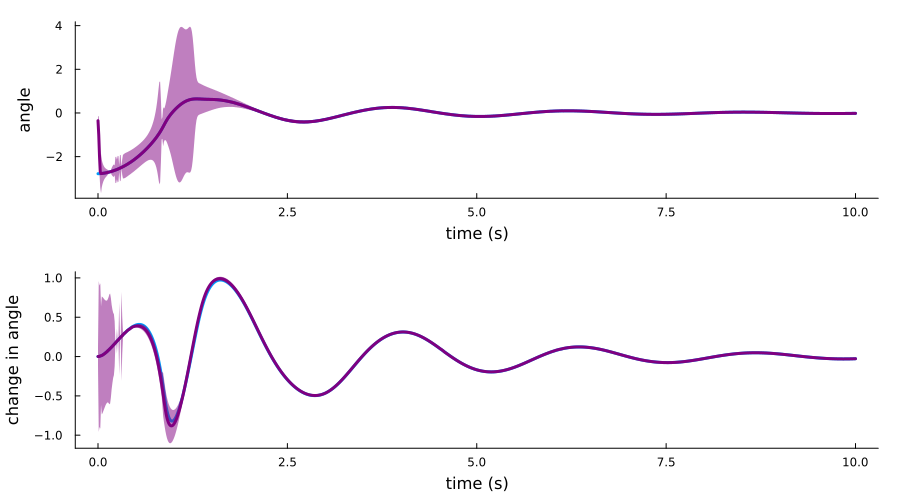

In [220]:
p1 = plot(time, z_[1,:], xlabel="time (s)", ylabel="angle")
plot!(time, z_est[1][1,:], ribbon=z_est[2][1,1,:], color="purple")
p2 = plot(time, z_[2,:], xlabel="time (s)", ylabel="change in angle")
plot!(time, z_est[1][2,:], ribbon=z_est[2][2,2,:], color="purple")
plot(p1, p2, layout=(2,1), size=(900,500))

## Expected Free Energy

From the agent's viewpoint, the evolution of these future variables are constrained by its generative model, rolled out into the future:
$$\begin{align}
p(y,z,u) &= \underbrace{q(z_{k})}_{\substack{\text{current}\\ \text{state}}} \cdot \underbrace{\prod_{t=k+1}^{k+T} p(y_t|z_t) \cdot p(z_t | z_{t-1}, u_t) p(u_t)}_{\text{generative model roll-out to future}} \, ,
\end{align}$$

where $y = (y_t, \dots, y_T)$, $z = (z_{t-1}, \dots, z_T)$ and $u = (u_t, \dots, u_T)$. 

Consider the varational free energy functional for estimating posterior beliefs $q(z,u)$ over future states and control signals, with an expectation over future observations $q(y \mid z)$: 

$$\begin{align}
H[q] &= \overbrace{\iint q(y \mid z)}^{\text{marginalize }y} \bigg( \overbrace{\int q(z,u) \log \frac{q(z,u)}{p(y,z,u)} }^{\text{variational free energy}}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z,u) \log \frac{q(z,u)}{p(y,z,u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z|u) q(u) \log \frac{q(z|u) q(u)}{p(y,z|u) p(u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg(\sum_{y,z} q(y,z|u) \log \frac{q(z|u) q(u)}{p(y,z|u) p(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg( \log q(u) + \log \frac{1}{p(u)}+ \underbrace{q(y,z|u) \log \frac{q(z|u)}{p(y,z|u)}}_{G(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \log \frac{q(u)}{p(u)\exp\left(- G(u)\right) } \mathrm{d}u  \, .
\end{align}$$

We can recognize a KL-divergence between $q(u)$ and the function $p(u)\exp\left(- G(u)\right)$, which will be minimal when $q(u) = p(u)\exp\left(- G(u)\right)$. The $G$ function is known as the _Expected Free Energy_. Let's look at it in detail for a future observation $t$,

$$ G(u_t) = \iint q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p(y_t, z_t \mid u_t)} \mathrm{d}y_t \, \mathrm{d}z_t \, ,$$

where 

$$\begin{align}
% q(y_t \mid z_t) &= \mathcal{N}(y_t \mid Cz_t, R) \\
% q(z_t \mid u_t) &= \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
% &= \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \\
p(y_t, z_t \mid u_t) &= \int p(y_t \mid z_t) p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
&= \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, ,
\end{align}$$

with the approximate posterior for the previous state $q(z_{t-1}) = \mathcal{N}(z_{t-1} \mid m_{t-1}, S_{t-1})$. The distribution $q(z_t \mid u_t)$ is constructed from the state transition:

$$q(z_t \mid u_t) = \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} = \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \, ,$$

and $q(y_t, z_t \mid u) = p(y_t \mid z_t) q(z_t \mid u_t)$ which is equivalent to $p(y_t, z_t \mid u_t)$ in this case. Note that - during planning and in linear Gaussian models - we can drive the KL-divergence between the approximate posteriors $q$ and the true posteriors $p$ to 0, thus allowing us to swap $q$ for $p$.

We will decompose this EFE function into ambiguity plus risk terms (see [lecture slides](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Intelligent-Agents-and-Active-Inference.ipynb) for more detail). To do so, we will decompose $p(y_t,z_t \mid u_t)$ into $p^\prime(y_t)p(z_t|y_t,u_t)$ where $p\prime(y_t)$ is a distribution over the goal state, a.k.a. a _goal prior_; $p^\prime(y) = \mathcal{N}(y \mid m_*, s_*)$. The derivation goes as follows:

$$\begin{align}
G(u_t) &= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p^\prime(y_t)p(z_t|y_t,u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{1}{p(z_t \mid y_t, u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{p(y_t \mid u_t)}{p(y_t \mid z_t)p(z_t \mid u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int q(y_t,z_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  p(z_t|u_t) p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int p(z|u) p(y|z) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t \\
&= \underbrace{\int  p(z_t|u_t) \int p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t}_{\text{ambiguity}} + \underbrace{\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t}_{\text{risk}} \ \, ,
\end{align}$$

Ambiguity is an expectation over an entropy, which - in the case of a Gaussian likelihood - is actually independent of the state,

$$\int p(y_t|z_t) \log p(y_t|z_t) \mathrm{d}y_t = \frac{1}{2}\big(\log 2\pi |R| - 1\big) \, ,$$

so the expectation over $p(z_t|u_t)$ doesn't even apply. As you may have noticed, the control $u_t$ doesn't affect ambiguity which means there is no information-seeking behaviour in linear Gaussian state-space models.

The risk term is a KL-divergence between the Gaussian,

$$\begin{align}
    p(y_t|u_t) &= \int p(y_t, z_t \mid u_t) \, \mathrm{d}z_t  \\
    &= \int \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, \mathrm{d}z_t \\
    &= \mathcal{N}(y_t \mid C(A m_{t-1} + Bu_t) , C(AS_{t-1}A^{\top} + Q) C^{\top} + R) \, ,
    \end{align}$$
    
and the goal prior $p^\prime(y_t)$. The formula for the KL-divergence between two Gaussians is (see [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions)):

$$\begin{align}
D_{\text{KL}}( \mathcal{N}(x \mid m_1, \sigma_1) || \mathcal{N}(x \mid m_2, \sigma_2) ) = \frac{1}{2} \Big[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + \text{tr}(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^{\top}\Sigma_2^{-1}(\mu_2 - \mu_1) \Big] \, .
\end{align}$$

For our distribution, this becomes:

$$\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t = \frac{1}{2} \Big[\log\frac{s_*}{|C(AS_{t-1}A^{\top} + Q) C^{\top} + R|} - 1 + \text{tr}(\frac{(C(AS_{t-1}A^{\top} + Q) C^{\top} + R)}{s_*}) + \frac{\big(m_* - (C(A m_{t-1} + Bu_t))\big)^2}{s_*}) \Big]$$


The decomposition is the same for any future state $t$. We may thus unroll the policy as $G(u) = \sum_{t=k+1}^{TT} G(u_t)$.

---

The above equations can be written down to form an objective function.

In [ ]:
function EFE(u::AbstractVector, 
             state::Tuple{AbstractVector, AbstractMatrix}, 
             goal::Tuple{Float64,Float64}; 
             time_horizon::Int64=1)
    "Expected Free Energy"
    
    # Unpack goal state
    m_star, S_star = goal
    iS = inv(S_star)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cEFE = 0.0
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        Jz  = Fz(m_tmin1)
        m_t = f(m_tmin1, u[t])
        S_t = Jz*S_tmin1*Jz' + 1e-8*diagm(ones(2))
        S_t = proj2psd!(S_t)

        # Unscented transform moments
        mU, SU, CU = UT(m_t, S_t, g, Q=R, D=4, α=1e-1, κ=1e-1)
        
        # E_q(z_t | u_t)[H[q(y_t | z_t)]]
        # ambiguity = 0.5(log(2π) + log(SU) - 1)
        ambiguity = 0.5(log(2π) + log(SU-CU'*inv(S_t)*CU) - 1)

        # D_KL[p(y_t | u_t) || p'(y_t)]
        risk = 0.5(log(det(S_star)/det(SU)) + 1 + (mU-m_star)'*iS*(mU-m_star) + tr(iS*SU))
        
        # Cumulate EFE
        cEFE += ambiguity + risk
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cEFE
end

We can use the Optim.jl library to auto-differentiate EFE and minimize it every time step.

In [ ]:
len_trial = 40
time = range(0, step=Δt, length=len_trial)

# Time horizon
len_horizon = 20;

In [ ]:
# Distribution around goal state
goal_state = [3.14, 0.0]
goal_obs   = (g(goal_state), 1e-5)

# Limits of controller
u_lims = (-18.0, 18.0)

# Preallocate
z_est = (zeros(2,len_trial), zeros(2,2,len_trial))
z_sim = zeros(2,len_trial)
y_sim = zeros(len_trial)
u_sim = zeros(len_trial)

# Initial state
z_0 = [0.1, 0.0]
z_sim[:,1] = z_0

# Initial belief
m_0 = z_0
S_0 = diagm(ones(2))

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[k-1])
   
    "State estimation"
    
    # Prediction step
    Jz       = Fz(m_kmin1)
    m_k_pred = f(m_kmin1, u_sim[k-1])
    S_k_pred = Jz*S_kmin1*Jz' + 1e-12*diagm(ones(2))
    
    # Correction step
    mU, SU, CU = UT(m_k_pred, S_k_pred, g, Q=R)
    K_t = CU*inv(SU)
    m_k = m_k_pred .+ K_t*(y_sim[k] - mU)
    S_k = S_k_pred .- K_t*SU*K_t'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(u, (m_k,S_k), goal_obs, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(len_horizon), Fminbox(LBFGS()); autodiff=:forward)
    
    # Extract minimizing control
    u_sim[k] = Optim.minimizer(results)[1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

In [ ]:
anim = @animate for (i,t) in enumerate(time)
   
    # Cartesian positions
    px,py = polar2cart(z_sim[:,i], l=leng)
    qx,qy = polar2cart(z_est[1][:,i], l=leng)
    gx,gy = polar2cart(goal_state, l=leng)
    
    # Concatenate
    pen_k = [0 0; px py]
    pnq_k = [0 0; qx qy]
    goalp = [0 0; gx gy]
    
    # Plot line
    plot(pen_k[:,1], pen_k[:,2], label=@sprintf("t = %.1f", t), alpha=0.5, xlims=[-1.5,1.5], ylims=[-1.5,1.5], aspect_ratio=:equal, color="black")
    plot!(pnq_k[:,1], pnq_k[:,2], color="purple")
    
    # Point masses
    scatter!([pen_k[2,1]], [pen_k[2,2]], color="black", alpha=0.5)
    scatter!([pnq_k[2,1]], [pnq_k[2,2]], color="purple")
    scatter!([goalp[2,1]], [goalp[2,2]], color="green")
    
end
gif(anim, "figures/1pendulum-trial1.gif", fps=100)

In [ ]:
p301 = scatter(time, y_sim, ylabel="observations", color="black")
plot!(time, goal_obs[1]*ones(len_trial), color="green", linestyle=:dash, label="goal obs")
p302 = plot(time, z_sim[1,:], ylabel="angle", label="true", color="blue")
plot!(time, z_est[1][1,:], ribbon=sqrt.(z_est[2][1,1,:]), label="inferred", color="purple")
plot!(time, goal_state[1]*ones(len_trial), color="green", linestyle=:dash, label="setpoint")
plot!(time, -goal_state[1]*ones(len_trial), color="green", linestyle=:dash, label="")
p303 = plot(time, u_sim, color="red", ylabel="Control")
plot(p301, p302, p303, layout=(3,1), size=(900,600))

In [ ]:
savefig("figures/1pendulum-trial1-timeplots.png")

### Trajectory

In [ ]:
len_trial = 20
time = range(0, step=Δt, length=len_trial)

# Time horizon
len_horizon = 10;

In [ ]:
function planned_trajectory(policy, current_state)
    "Generate future states and observations"
    
    # Extract time horizon
    time_horizon = length(policy)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = current_state
    
    # Track predicted observations
    z_m = zeros(2,time_horizon)
    z_S = zeros(2,2,time_horizon)
    y_m = zeros(time_horizon)
    y_v = zeros(time_horizon)
    
    for t in 1:time_horizon
        
        # Prediction step
        Jz         = Fz(m_tmin1)
        z_m[:,t]   = f(m_tmin1, policy[t])
        z_S[:,:,t] = Jz*S_tmin1*Jz' + 1e-8*diagm(ones(2))
        
        # Predicted observations
        y_m[t],y_v[t],_ = UT(z_m[:,t],z_S[:,:,t],g, Q=R)
        
        # Update previous state
        m_tmin1 = z_m[:,t]
        S_tmin1 = z_S[:,:,t]
        
    end
    return z_m, z_S, y_m, y_v
end

In [ ]:
# Distribution around goal state
goal_state = (3.14, 1e-5)

# Limits of controller
u_lims = (-10.0, 10.0)

# Preallocate
z_est = (zeros(2,len_trial), zeros(2,2,len_trial))
z_pln = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
y_pln = (zeros(len_trial, len_horizon), zeros(len_trial,len_horizon))
z_sim = zeros(2,len_trial)
y_sim = zeros(len_trial)
u_sim = zeros(len_trial)

# Initial belief
m_0 = ones(2)
S_0 = 3.0*diagm(ones(2))

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
z_kmin1 = [0.,0.]

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[k-1])
   
    "State estimation"
    
    # Prediction step
    Jz       = Fz(m_kmin1)
    m_k_pred = f(m_kmin1, u_sim[k-1])
    S_k_pred = Jz*S_kmin1*Jz' + 1e-8*diagm(ones(2))

    # Correction step
    mU, SU, CU = UT(m_k_pred, S_k_pred, g, Q=R)
    K_t = CU*inv(SU)
    m_k = m_k_pred .+ K_t*(y_sim[k] - mU)
    S_k = S_k_pred .- K_t*SU*K_t'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u_t::AbstractVector) = EFE(u_t, (m_k, S_k), goal_state, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(len_horizon), Fminbox(LBFGS()); autodiff=:forward)
    policy = Optim.minimizer(results)
    
    # Planning
    z_pln[1][k,:,:], z_pln[2][k,:,:,:], y_pln[1][k,:], y_pln[2][k,:] = planned_trajectory(policy, (m_k,S_k))
    
    # Execute first planned action only
    u_sim[k] = policy[1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

In [ ]:
anim = @animate for k = 2:(len_trial-len_horizon)
    
    p201 = plot(time, goal_state[1]*ones(len_trial), color="green", linestyle=:dash, label="setpoint", ylims=[-1.5, 1.0])
    scatter!(time[1:k], y_sim[1:k], color="black", label="observations")
    plot!(time[k:k+len_horizon-1], y_pln[1][k,:], ribbon=sqrt.(y_pln[2][k,:]), label="planned", color="orange")
    
    p202 = plot(time[1:k], z_sim[1,1:k], xlims=[time[1], time[end]], label="true", ylabel="Position", xlabel="Time [s]")
    plot!(time[k:k+len_horizon-1], z_pln[1][k,1,:], ribbon=sqrt.(z_pln[2][k,1,1,:]), label="planned", color="orange")
    plot!(time[1:k], z_est[1][1,1:k], ribbon=sqrt.(z_est[2][1,1,1:k]), label="inferred", color="purple", ylims=[-2,2])
    
    p203 = plot(time[1:k], u_sim[1:k], xlims=[time[1], time[end]], color="red", ylabel="Control", ylims=u_lims.*1.1)
    
    plot(p201, p202, p203, layout=(3,1), size=(900,900))
end
gif(anim, "figures/planning.gif")

In [ ]:
function EFE(u::AbstractVector, 
             state::Tuple{Vector{Float64}, Matrix{Float64}}, 
             goal::Tuple{Float64,Float64}; 
             time_horizon::Int64=1)
    "Expected Free Energy"
    
    # Unpack goal state
    m_star, S_star = goal
    iS = inv(S_star)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cAmbiguity = 0.0
    cRisk      = 0.0
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        Jz    = Fz(m_tmin1)
        m_t   = f(m_tmin1, u[t])
        S_t = Jz*S_tmin1*Jz' + 1e-8*diagm(ones(2))

        # Unscented transform moments
        mU, SU, CU = UT(m_t, S_t, g, Q=R, D=1)
        
        # E_q(z_t | u_t)[H[q(y_t | z_t)]]
        ambiguity = 0.5(log(2π) + log(SU-CU'*inv(S_t)*CU) - 1)

        # D_KL[p(y_t | u_t) || p'(y_t)]
        risk = 0.5(log(det(S_star)/det(SU)) + 1 + (mU-m_star)'*iS*(mU-m_star) + tr(iS*SU))
        
        # Cumulate EFE terms
        cAmbiguity += ambiguity
        cRisk +    = risk
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cAmbiguity, cRisk
end